# Seismic modeling with COFII.jl and AzureClusterlessHPC.jl

This examples demonstrates how to model seismic data using Chevron's `COFII` framework. Unlike the [original example](https://github.com/ChevronETC/Examples/blob/main/30_forward_modeling/05_DynamicParallel.ipynb), which is based on Azure Scale Sets, we use `AzureClusterlessHPC` to execute the computations as an Azure Batch job.

The first step is setting environment variables that point to our Azure Batch and Storage credentials, as well as to our parameter file. This file contains basic parameters of our batch pool, including the pool and job id, the VM type and the number of nodes in the pool.

In [1]:
# Install required packages for this example
using Pkg
Pkg.add(["DistributedArrays", "DistributedOperations", "Schedulers", "PyPlot"])
Pkg.add(["DistributedJets", "Jets", "WaveFD", "JetPackWaveFD"])

# Set paths to credentials + parameters
ENV["CREDENTIALS"] = joinpath(pwd(), "../..", "credentials.json")
ENV["PARAMETERS"] = joinpath(pwd(), "parameters.json")

# Load package
using AzureClusterlessHPC
batch_clear();

Next, we create the batch pool, which involves passing a startup script that specifies the necessary Julia packages that will installed on each node in the pool. In this example, this includes the COFII packages as specified [here](https://github.com/ChevronETC/Examples/blob/main/00_add_packages/00_add_packages.ipynb).

In [2]:
# Create pool
startup_script = "pool_startup_script_cofii.sh"
create_pool_and_resource_file(startup_script);

Pool 1 of 1 in canadacentral already exists.


We load all necessary packages on our local machine, as well as on the remote batch workers using the `@batchdef` macro:

In [3]:
@batchdef using Distributed, DistributedArrays, DistributedJets, Jets, WaveFD
@batchdef using JetPackWaveFD, DistributedOperations, Schedulers, Random;

Next, we read the Marmousi velocity model for which we will model the seismic data:

In [4]:
# Load model
v = read!("../../data/marmousi_vp_20m_176x851.bin", Array{Float32}(undef, 176, 851));
dz, dx = 20.0, 20.0
nz, nx = size(v)
@show dz, dx
@show nz, nx;

(dz, dx) = (20.0, 20.0)
(nz, nx) = (176, 851)


We specify the range of seismic source locations for which the data will be generated. In this example, we create 10 source locations:

In [5]:
# Source range
sx = range(0, length=8, stop=(851-1)*20)
nshots = length(sx)
@show nshots;

nshots = 8


Now, we define the modeling function for generating the data. This function takes the source number, shot locations and velocity model as input arguments and returns the computed seismic shot record. We also specify a set of keyword arguments and a path to where we store temporary wavefield files. Our modeling function and variables that need to be available to batch workers are tagged with the `@batchdef` macro:

In [6]:
# Keywords for modeling operator
kwargs = (reportinterval = 0, freqQ=5, srcfieldfile="", nsponge = 200)
@batchdef scratch = pwd()   # dump in current dir
@batchdef isdir(scratch);

In [7]:
# Single shot function
@batchdef function modelshot(isrc, sx, _v; kwargs...)
    nz,nx,dz,dx = 176,851,20.0,20.0   
    print("modeling shot $(isrc) on $(gethostname()) with id $(myid())...\n")
    F = JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        isinterior = true,
        ntrec = 1101,
        dtrec = 0.002,
        dtmod = 0.001,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=5.0),
        sx = sx[isrc],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(length(0:1:nx-1)),
        srcfieldfile = joinpath(scratch, "field-$isrc.$(randstring()).bin"),
        reportinterval=1000,
        kwargs...)
    
    d = F*fetch(_v)
    print("...done modeling shot $(isrc) on $(gethostname()) with id $(myid())\n")
    print("extrema of shot $(isrc) is $(extrema(d))\n")

    return d
end;

To avoid passing the velocity as an argument to our function multiple times (e.g. for multi-task jobs), we broadcast the velocity beforehand. This uploads the velocity to blob storage and returns a reference to it in form of a `BlobFuture`, which can be passed to our function:

In [8]:
_v = @bcast(v);

Before running the computations on Azure Batch, we make sure that our functions works as expected by modeling a single shot on our local machine. By calling the function without any macros, the function is executed locally:

In [9]:
# Model single shot locally
d_local = modelshot(5, sx, v);

modeling shot 5 on pwitte-pc01 with id 1...


┌ Info: nonlinear forward on pwitte-pc01, srcfieldfile=/home/pwitte/.julia/dev/AzureClusterlessHPC/examples/cofii/field-5.NVEvNaDk.bin
└ @ JetPackWaveFD /home/pwitte/.julia/packages/JetPackWaveFD/Tq8Ny/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:472
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  1000 of  2201    8.14 MCells/s (IO=88.61, EX= 7.48, PR= 3.11) -- rms d,p; 2.0938e+00 1.1068e+00
└ @ JetPackWaveFD /home/pwitte/.julia/packages/JetPackWaveFD/Tq8Ny/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:863
┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  2000 of  2201    5.50 MCells/s (IO=90.27, EX= 3.51, PR= 5.09) -- rms d,p; 2.2355e+00 9.0569e-01
└ @ JetPackWaveFD /home/pwitte/.julia/packages/JetPackWaveFD/Tq8Ny/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:863


...done modeling shot 5 on pwitte-pc01 with id 1
extrema of shot 5 is (-59.07576f0, 108.17611f0)


┌ Info: Prop2DAcoIsoDenQ_DEO2_FDTD, nonlinear forward, time step  2201 of  2201    6.01 MCells/s (IO=89.93, EX= 3.65, PR= 5.27) -- rms d,p; 2.2520e+00 8.2876e-01
└ @ JetPackWaveFD /home/pwitte/.julia/packages/JetPackWaveFD/Tq8Ny/src/jop_prop2DAcoIsoDenQ_DEO2_FDTD.jl:863


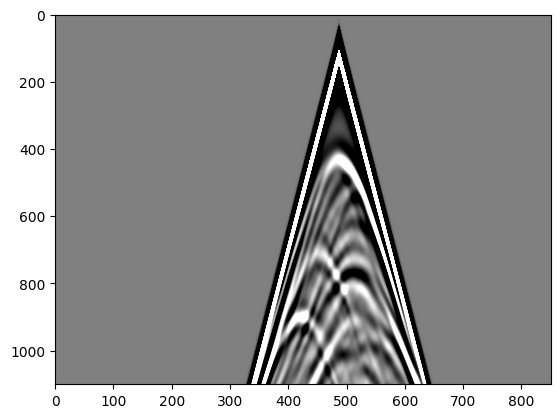

In [10]:
using PyPlot
imshow(d_local, vmin=-1, vmax=1, cmap="gray", aspect="auto");

Now that we know that our function works as expected, we can run a sample computation for a single shot record with Azure Batch. We execute the function with the `@batchexec` macro, which returns a batch controller with a Julia Future to the result.

In [11]:
# Model single shot remotely
bctrl = @batchexec modelshot(5, sx, _v);

The result is stored as a blob in Azure Storage and can be loaded into local memory using Julia's `fetch` function. The function is blocking and returns the result as soon as the batch job has successfully terminated.

In [12]:
# Fetch single shot
d_batch = fetch(bctrl); delete_job(bctrl);

Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Uploading file v.dat to container [azureclusterlesstemp]...
Creating job [CofiiRTM_KBI4gPeE_1]...
Uploading file /home/pwitte/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/pwitte/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
..................
Fetch output from task task_1


As a sanity check, we plot the shot record to make sure it looks like our previously computed data:

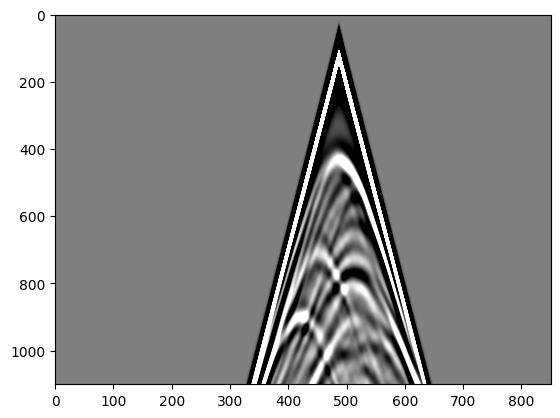

sum(d_batch - d_local) = -0.10832409f0


In [13]:
imshow(d_batch, vmin=-1, vmax=1, cmap="gray", aspect="auto")
@show sum(d_batch - d_local);

Finally, we compute the seismic data for all source location by calling the `pmap` function with the `@batchexec` macro. This submits a multi-task Batch job to Azure and returns a batch controller with futures to the results:

In [14]:
# Model multiple shots remotely
bctrl = @batchexec pmap(i->modelshot(i, sx, _v; kwargs...), 1:nshots);

  1.844371 seconds (140.81 k allocations: 8.755 MiB, 11.31% compilation time)


As before, we can load the results into memory by calling the fetch function, which allows us to plot the data:

In [15]:
# Fetch all shots
d_pmap = fetch(bctrl);

Monitoring tasks for 'Completed' state, timeout in 60 minutes ...Creating job [CofiiRTM_FjnkpX3K_1]...
Uploading file /home/pwitte/.julia/dev/AzureClusterlessHPC/src/runtime/application-cmd to blob container [azureclusterlesstemp]...
Uploading file /home/pwitte/.julia/dev/AzureClusterlessHPC/src/runtime/batch_runtime.jl to blob container [azureclusterlesstemp]...
Uploading file packages.dat to container [azureclusterlesstemp]...
Uploading file task_1.dat to container [azureclusterlesstemp]...
Uploading file task_2.dat to container [azureclusterlesstemp]...
Uploading file task_3.dat to container [azureclusterlesstemp]...
Uploading file task_4.dat to container [azureclusterlesstemp]...
Uploading file task_5.dat to container [azureclusterlesstemp]...
Uploading file task_6.dat to container [azureclusterlesstemp]...
Uploading file task_7.dat to container [azureclusterlesstemp]...
Uploading file task_8.dat to container [azureclusterlesstemp]...
.........
Fetch output from task task_4.
Fetch 

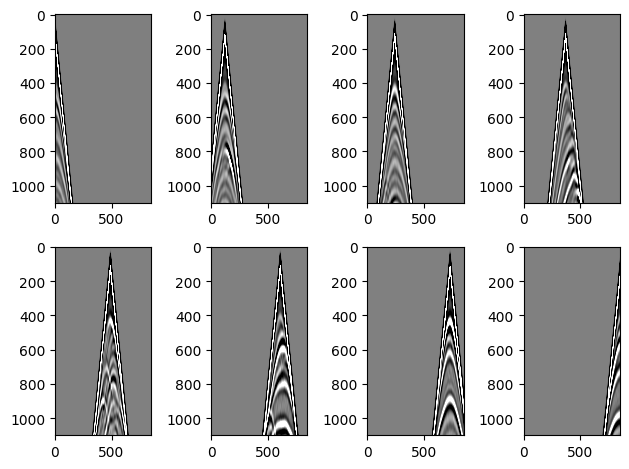

In [16]:
for i=1:nshots
    subplot(2, Int(round(nshots/2)), i)
    imshow(d_pmap[i], vmin=-1, vmax=1, cmap="gray", aspect="auto")
end
tight_layout();

Before heading out, we clean up all Azure resources, including the job, blob container and batch pool:

In [17]:
destroy!(bctrl);

## Copyright

Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License (MIT). See LICENSE in the repo root for license information.